# Redes Neuronales Recurrentes

A lo largo de este notebook de prácticas haremos varios ejemplos, tanto con RNNs básicas como con LSTMs, y veremos las diferencias.

También trabajaremos con problemas con una única variable y con problemas multivariantes.

# 1. Predicción de demanda de vuelos en una aerolinea

El primer problema que abordaremos es el de tratar de predecir los viajeros de una determinada aerolinea. Para ello, carguaremos los datos y los transformaremos de forma que podamos utilizarlos con nuestros modelos.

In [1]:
# Nos descargamos los datos
import requests

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
response = requests.get(url)
with open("airline-passengers.csv", "wb") as file:
    file.write(response.content)

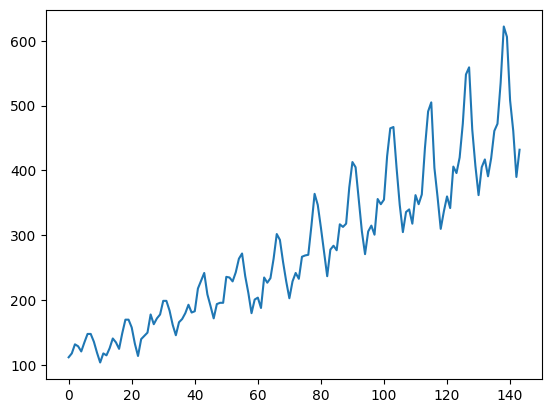

In [2]:
# Y los visualizamos
import pandas
import matplotlib.pyplot as plt
dataset_raw = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
plt.plot(dataset_raw)
plt.show()

Inspeccionamos los datos:

In [3]:
dataset_raw

,Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


### **Transformación de los datos**

Ahora necesitamos convertir los datos de forma que la RNN pueda usarlos. Daos cuenta de que por el momento tenemos únicamente un conjunto de valores secuenciales, pero vamos a querer aplicar un algoritmo supervisado (las RNNs lo son).

Así que... ¿Dónde están las etiquetas?

¡En los propios datos!

Nosotros tenemos esto:

<img src="https://miro.medium.com/max/1400/1*nhffHtudbkqG0yYIF3oeBA.png">

Donde la etiqueta para una determinada secuencia de longitud N será la muestra N+1:

<img src="https://miro.medium.com/max/1400/1*murkc0tNsvgdQDVgKqSdfQ.png">

Y esta transformación de datos es muy sencilla con Python:

In [4]:
# convertimos los datos a un formato entendible por la RNN
import numpy as np

def create_dataset(dataset, look_back_memory=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back_memory-1):
        dataX.append(dataset[i:i+look_back_memory, 0])
        dataY.append(dataset[i+look_back_memory, 0]) # en este caso si queremos predecir más de uno deberíamos hacer lo siguiente "i+look_back_memory:i+look_back_memory+2" para predecir el siguiente
    return np.array(dataX), np.array(dataY)

Imaginémonos que queremos, a partir de un valor, predecir el siguiente. Es decir, tendríamos un "ventana" de un único elemento. Para ello, tendríamos que hacer lo siguiente:

In [5]:
dataX, dataY = create_dataset(dataset_raw.values, look_back_memory=1)
print(dataX.shape)
print(dataY.shape)

(142, 1)
(142,)


¡Atención! Esto no significa que nuestra memoria sea de un elemento. Recordad que las RNNs tienen una "cinta transportadora" (estado) en la que acumulan información. Por lo tanto, lo único que indica esta ventana, es la cantidad de muestras en la que se basará para hacer la predicción en cada instante temporal.

Pero luego, la RNN, podrá almacenar información de varias de esas predicciones.

Si quisieramos que nuestra RNN utilizara más de una muestra para cada predicción, tendríamos que aumentar el tamaño de la ventana de 1 a N. Esto podríamos hacerlo modificando el valor de `look_back_memory`.

In [6]:
# Por ejemplo, para una ventana de 10 elementos:
dataX, dataY = create_dataset(dataset_raw.values, look_back_memory=10)
print(dataX.shape)
print(dataY.shape)

(133, 10)
(133,)


###**Predicción con una RNN básica**

Ahora que ya sabemos como transformar los datos al formato pertinente, podemos comenzar a implementar el modelo. 

En este caso, utilizaremos:

- Una red recurrente (`SimpleRNN`) con una celda y `10` neuronas, seguida de una capa `Dense` con activación `linear` (recordad que estamos haciendo regresión).
- Como optimizador utilizaremos `Adam` y como función de pérdidas el `mean_squared_error`.

In [7]:
import numpy

def create_dataset(dataset, look_back_memory=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back_memory-1):
        dataX.append(dataset[i:i+look_back_memory, 0])
        dataY.append(dataset[i+look_back_memory, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [8]:
# hacemos el import de todo lo que utilizaremos
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [9]:
# fijamos la semilla para obtener resultados reproducibles
numpy.random.seed(42)

In [10]:
# cargamos los datos
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [11]:
# normalizamos el dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [12]:
# dividimos en train y test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [13]:
# transformamos los datos para crearnos N registros con T timestamps cada uno 
# (uno por cada instante temporal hasta completar el tamaño de la ventana) y 
# las V variables de las que disponga nuestro dataset. En este caso, vamos a 
# escoger una ventana con un único timestamp T=1 y solo tendremos una variable,
# con lo que V=1 (número de pasajeros).
look_back_memory = 1
trainX, trainY = create_dataset(train, look_back_memory)
testX, testY = create_dataset(test, look_back_memory)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(94, 1) (94,)
(46, 1) (46,)


In [14]:
# Nos aseguramos de que las dimensiones de las entradas son las correctas:
# (número de ventanas de T elementos, los T elementos de cada ventana, las V variables de cada timestamp)
variables = 1 # (trainX.shape[1])
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back_memory, variables))
testX = numpy.reshape(testX, (testX.shape[0], look_back_memory, variables))
print(trainX.shape)
print(testX.shape)

(94, 1, 1)
(46, 1, 1)


In [15]:
# creamos el modelo y lo entrenamos
model = Sequential() #initialize model
model.add(SimpleRNN(10, input_shape=(look_back_memory, variables)))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
94/94 [==============================] - 1s 735us/step - loss: 0.0441
Epoch 2/100
94/94 [==============================] - 0s 829us/step - loss: 0.0159
Epoch 3/100
94/94 [==============================] - 0s 781us/step - loss: 0.0116
Epoch 4/100
94/94 [==============================] - 0s 804us/step - loss: 0.0085
Epoch 5/100
94/94 [==============================] - 0s 709us/step - loss: 0.0059
Epoch 6/100
94/94 [==============================] - 0s 865us/step - loss: 0.0043
Epoch 7/100
94/94 [==============================] - 0s 706us/step - loss: 0.0032
Epoch 8/100
94/94 [==============================] - 0s 776us/step - loss: 0.0026
Epoch 9/100
94/94 [==============================] - 0s 861us/step - loss: 0.0023
Epoch 10/100
94/94 [==============================] - 0s 861us/step - loss: 0.0021
Epoch 11/100
94/94 [==============================] - 0s 861us/step - loss: 0.0020
Epoch 12/100
94/94 [==============================] - 0s 704us/step - loss: 0.0020
Epoch 13/100


In [16]:
# vamos a ver qué tal funciona nuestro modelo
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2/2 [==============================] - 0s 8ms/step


In [17]:
trainPredict.shape

(94, 1)

In [18]:
trainY.shape

(94,)

In [19]:
# una vez hechas las predicciones, tenemos que des-normalizarlas
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])

In [20]:
# y ahora calculamos el error cometido en train y en test
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.90 RMSE
Test Score: 54.56 RMSE


In [21]:
# por como creamos el dataset de entrenamiento, ahora tenemos que desplazar
# nuestras predicciones para que "cuadren" con el eje x de los datos originales
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back_memory:len(trainPredict)+look_back_memory, :] = trainPredict

In [22]:
# y lo mismo para el test
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back_memory*2)+1:len(dataset)-1, :] = testPredict

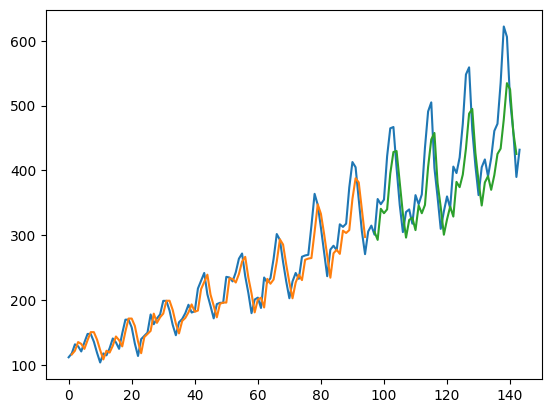

In [23]:
# y mostramos los datos originales, la predicción en training y la predicción en test
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Estos resultados son los que hemos conseguido con una RNN básica. ¿Os animáis a probar con una LSTM?

### **Ejercicio 1**

Acabamos de entrenar un modelo RNN para predecir la demanda de vuelos por día. Ahora os toca a vosotros: en vez de utilizar la celda RNN, utilizad la LSTM con exactamente la misma configuración.

In [24]:
from keras.layers import LSTM

# creamos el modelo y lo entrenamos
model = Sequential() #initialize model
model.add(LSTM(10, input_shape=(look_back_memory, variables)))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
94/94 [==============================] - 1s 949us/step - loss: 0.0516
Epoch 2/100
94/94 [==============================] - 0s 951us/step - loss: 0.0241
Epoch 3/100
94/94 [==============================] - 0s 947us/step - loss: 0.0175
Epoch 4/100
94/94 [==============================] - 0s 947us/step - loss: 0.0156
Epoch 5/100
94/94 [==============================] - 0s 946us/step - loss: 0.0142
Epoch 6/100
94/94 [==============================] - 0s 947us/step - loss: 0.0127
Epoch 7/100
94/94 [==============================] - 0s 860us/step - loss: 0.0113
Epoch 8/100
94/94 [==============================] - 0s 864us/step - loss: 0.0099
Epoch 9/100
94/94 [==============================] - 0s 860us/step - loss: 0.0087
Epoch 10/100
94/94 [==============================] - 0s 871us/step - loss: 0.0074
Epoch 11/100
94/94 [==============================] - 0s 902us/step - loss: 0.0061
Epoch 12/100
94/94 [==============================] - 0s 863us/step - loss: 0.0052
Epoch 13/100


In [26]:
# vamos a ver qué tal funciona nuestro modelo

# completad las lineas siguientes
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2/2 [==============================] - 0s 0s/step


In [27]:
# una vez hechas las predicciones, tenemos que des-normalizarlas
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])

In [28]:
# y ahora calculamos el error cometido en train y en test
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.08 RMSE
Test Score: 49.19 RMSE


In [29]:
# por como creamos el dataset de entrenamiento, ahora tenemos que desplazar
# nuestras predicciones para que "cuadren" con el eje x de los datos originales
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back_memory:len(trainPredict)+look_back_memory, :] = trainPredict

In [30]:
# y lo mismo para el test
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back_memory*2)+1:len(dataset)-1, :] = testPredict

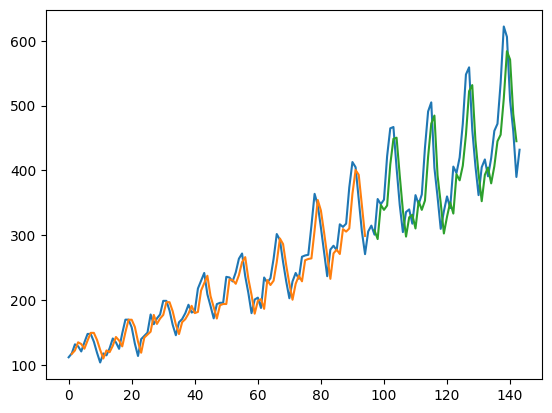

In [31]:
# y mostramos los datos originales, la predicción en training y la predicción en test
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### **Ejercicio 2** 

Entrena un modelo RNN básico igual al primero, pero con una ventana de 10 timestamps.

In [32]:
# hacemos el import de todo lo que utilizaremos
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fijamos la semilla para obtener resultados reproducibles
numpy.random.seed(42)

# cargamos los datos
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalizamos el dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# dividimos en train y test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [33]:
# transformamos los datos para crearnos N registros con T timestamps cada uno 
# (uno por cada instante temporal hasta completar el tamaño de la ventana) y 
# las V variables de las que disponga nuestro dataset. En este caso, vamos a 
# escoger una ventana con un único timestamp T=10 y solo tendremos una variable,
# con lo que V=1 (número de pasajeros).


# completad las líneas siguientes

look_back_memory = 10
trainX, trainY = create_dataset(train, look_back_memory)
testX, testY = create_dataset(test, look_back_memory)

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(85, 10) (85,)
(37, 10) (37,)


In [34]:
# Nos aseguramos de que las dimensiones de las entradas son las correctas:
# (número de ventanas de T elementos, los T elementos de cada ventana, las V variables de cada timestamp)
variables = 1 # (trainX.shape[1])
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back_memory, variables))
testX = numpy.reshape(testX, (testX.shape[0], look_back_memory, variables))
print(trainX.shape)
print(testX.shape)

(85, 10, 1)
(37, 10, 1)


In [35]:
# creamos el modelo y lo entrenamos
model = Sequential() #initialize model

# completad las lineas siguientes

model.add(LSTM(10, input_shape=(look_back_memory, variables)))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
85/85 [==============================] - 1s 2ms/step - loss: 0.0205
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 4/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 5/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 10/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 11/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 12/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 13/100
85/85 [=================

2/2 [==============================] - 0s 0s/step
Train Score: 20.89 RMSE
Test Score: 41.02 RMSE


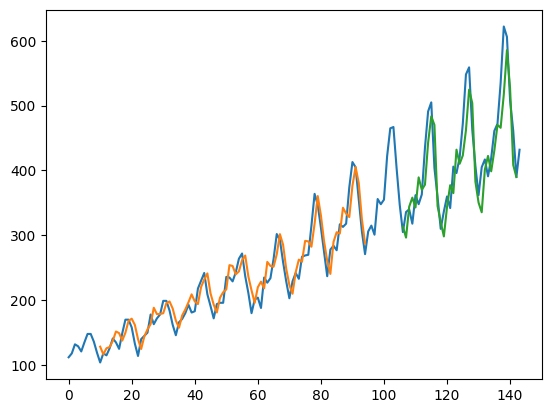

In [36]:

# vamos a ver qué tal funciona nuestro modelo
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# una vez hechas las predicciones, tenemos que des-normalizarlas
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])

# y ahora calculamos el error cometido en train y en test
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# por como creamos el dataset de entrenamiento, ahora tenemos que desplazar
# nuestras predicciones para que "cuadren" con el eje x de los datos originales
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back_memory:len(trainPredict)+look_back_memory, :] = trainPredict

# y lo mismo para el test
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back_memory*2)+1:len(dataset)-1, :] = testPredict

# y mostramos los datos originales, la predicción en training y la predicción en test
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### **Ejercicio 3**

Hemos visto que con la RNN y una ventana de 10 timestamps podemos mejorar los resultados obtenidos con una ventana de 1 timestamp. ¿Se os ocurre como intentar mejorar estos resultados?

Sabemos que las RNN básicas sufren problemas de memoria, y que las LSTM son capaces de mitigarlos. Además, hemos comprobado de forma práctica que las LSTMs consiguen un mejor ajuste.

Entrena una LSTM (https://keras.io/api/layers/recurrent_layers/lstm/) con los datos anteriores, una ventana de 10 timestamps y sin rellenar los T timestamps iniciales con 0's.

In [37]:
# transformamos los datos para crearnos N registros con T timestamps cada uno 
# (uno por cada instante temporal hasta completar el tamaño de la ventana) y 
# las V variables de las que disponga nuestro dataset. En este caso, vamos a 
# escoger una ventana con un único timestamp T=10 y solo tendremos una variable,
# con lo que V=1 (número de pasajeros).


# completad las líneas siguientes

look_back_memory = 10
trainX, trainY = create_dataset(train, look_back_memory)
testX, testY = create_dataset(test, look_back_memory)

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(85, 10) (85,)
(37, 10) (37,)


In [38]:
# Nos aseguramos de que las dimensiones de las entradas son las correctas:
# (número de ventanas de T elementos, los T elementos de cada ventana, las V variables de cada timestamp)
variables = 1 # (trainX.shape[1])
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back_memory, variables))
testX = numpy.reshape(testX, (testX.shape[0], look_back_memory, variables))
print(trainX.shape)
print(testX.shape)

(85, 10, 1)
(37, 10, 1)


In [39]:
# creamos el modelo y lo entrenamos
model = Sequential() #initialize model

# completad las lineas siguientes

model.add(SimpleRNN(10, input_shape=(look_back_memory, variables)))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
85/85 [==============================] - 1s 1ms/step - loss: 0.0244
Epoch 2/100
85/85 [==============================] - 0s 1ms/step - loss: 0.0172
Epoch 3/100
85/85 [==============================] - 0s 1ms/step - loss: 0.0136
Epoch 4/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 5/100
85/85 [==============================] - 0s 1ms/step - loss: 0.0103
Epoch 6/100
85/85 [==============================] - 0s 1ms/step - loss: 0.0080
Epoch 7/100
85/85 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 8/100
85/85 [==============================] - 0s 1ms/step - loss: 0.0060
Epoch 9/100
85/85 [==============================] - 0s 1ms/step - loss: 0.0058
Epoch 10/100
85/85 [==============================] - 0s 1ms/step - loss: 0.0050
Epoch 11/100
85/85 [==============================] - 0s 1ms/step - loss: 0.0050
Epoch 12/100
85/85 [==============================] - 0s 1ms/step - loss: 0.0045
Epoch 13/100
85/85 [=================

In [40]:

# vamos a ver qué tal funciona nuestro modelo
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# una vez hechas las predicciones, tenemos que des-normalizarlas
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])

# y ahora calculamos el error cometido en train y en test
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 0s/step
Train Score: 18.38 RMSE
Test Score: 44.56 RMSE


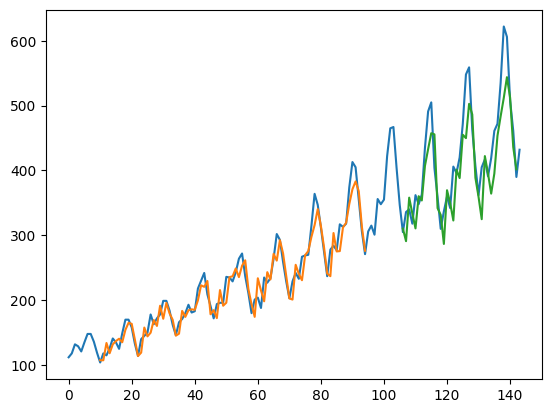

In [41]:
# por como creamos el dataset de entrenamiento, ahora tenemos que desplazar
# nuestras predicciones para que "cuadren" con el eje x de los datos originales
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back_memory:len(trainPredict)+look_back_memory, :] = trainPredict

# y lo mismo para el test
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back_memory*2)+1:len(dataset)-1, :] = testPredict

# y mostramos los datos originales, la predicción en training y la predicción en test
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### **Ejercicio 4**

Realiza lo mismo que en el ejercicio 3, pero con unidades GRU. Compara los resultados obtenidos.

In [42]:
# necesitarás importar algo...
from keras.models import Sequential
from keras.layers import GRU

In [43]:
# Nos aseguramos de que las dimensiones de las entradas son las correctas:
# (número de ventanas de T elementos, los T elementos de cada ventana, las V variables de cada timestamp)
variables = 1 # (trainX.shape[1])
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back_memory, variables))
testX = numpy.reshape(testX, (testX.shape[0], look_back_memory, variables))
print(trainX.shape)
print(testX.shape)

(85, 10, 1)
(37, 10, 1)


In [44]:
# creamos el modelo y lo entrenamos
model = Sequential() #initialize model

# completad las lineas siguientes

model.add(GRU(10, input_shape=(look_back_memory, variables)))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
85/85 [==============================] - 1s 2ms/step - loss: 0.0340
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 4/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 5/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 10/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 11/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 12/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 13/100
85/85 [=================

In [45]:

# vamos a ver qué tal funciona nuestro modelo
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# una vez hechas las predicciones, tenemos que des-normalizarlas
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])

# y ahora calculamos el error cometido en train y en test
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 0s/step
Train Score: 20.38 RMSE
Test Score: 49.81 RMSE


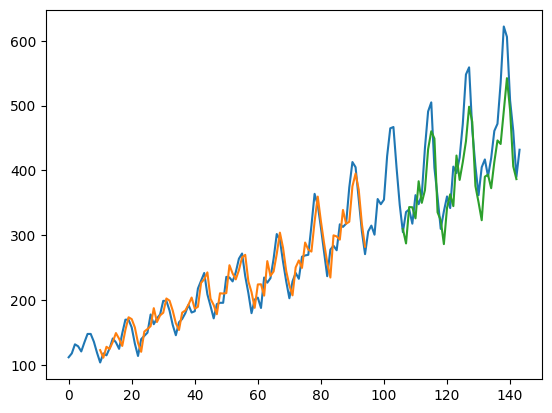

In [46]:
# por como creamos el dataset de entrenamiento, ahora tenemos que desplazar
# nuestras predicciones para que "cuadren" con el eje x de los datos originales
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back_memory:len(trainPredict)+look_back_memory, :] = trainPredict

# y lo mismo para el test
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back_memory*2)+1:len(dataset)-1, :] = testPredict

# y mostramos los datos originales, la predicción en training y la predicción en test
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()